##### **Load Libraries**

In [37]:
import time
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, f1_score


from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

##### **OVERSAMPLING DATASET TRAINING**

##### **TF-IDF Vectorization**

In [38]:
rostrain_df = pd.read_csv("Datasets/train_allcase_balanced(ros).csv")
rostest_df = pd.read_csv("Datasets/test_allcase_raw.csv")

col_text = 'preprocessed_news'
col_label = 'label' 

rostrain_df[col_text] = rostrain_df[col_text].fillna('')
rostest_df[col_text] = rostest_df[col_text].fillna('')

X_train = rostrain_df[col_text]
y_train = rostrain_df[col_label]

X_test = rostest_df[col_text]
y_test = rostest_df[col_label]

# TF-IDF Vectorization (Fit on TRAIN only)
print("🔹 Vectorizing text with TF-IDF ...")
start_time = time.time()

rostfidf = TfidfVectorizer(
    max_features=30_000,
    ngram_range=(1,2),
    min_df=2,
    max_df=0.9,
    sublinear_tf=True
)

X_train_tfidf = rostfidf.fit_transform(tqdm(X_train, desc="Fitting TF-IDF"))
X_test_tfidf = rostfidf.transform(tqdm(X_test, desc="Transforming Test Set"))

print(f"✅ TF-IDF completed in {(time.time() - start_time):.2f}s\n")

🔹 Vectorizing text with TF-IDF ...


Transforming Test Set: 100%|██████████| 56352/56352 [00:01<00:00, 47442.20it/s]


✅ TF-IDF completed in 19.06s



##### **Linear SVM**

🚀 Training LinearSVC Model...

✅ Training done in 81.26 seconds

📊 Evaluating model...
Training Accuracy: 94.93%
Testing  Accuracy: 86.45%
Weighted F1 Score: 0.8674

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     18140
           1       0.53      0.69      0.60      3281
           2       0.92      0.89      0.91     34931

    accuracy                           0.86     56352
   macro avg       0.76      0.81      0.78     56352
weighted avg       0.87      0.86      0.87     56352



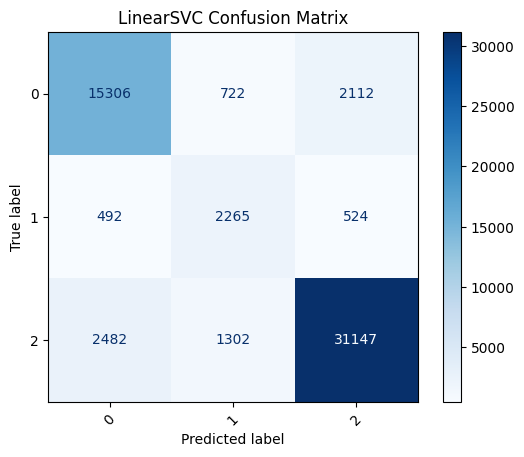

In [ ]:
# Train LinearSVC
print("🚀 Training LinearSVC Model...")

lsvc_model = LinearSVC(random_state=42)

start_time = time.time()
lsvc_model.fit(X_train_tfidf, y_train)
elapsed = time.time() - start_time

print(f"\n✅ Training done in {elapsed:.2f} seconds\n")     


# Model Evaluation
print("📊 Evaluating model...")

y_pred = lsvc_model.predict(X_test_tfidf)
train_pred = lsvc_model.predict(X_train_tfidf)

print(f"Training Accuracy: {accuracy_score(y_train, train_pred)*100:.2f}%")
print(f"Testing  Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("LinearSVC Confusion Matrix")
plt.show()

In [ ]:

# Save Model and Vectorizer
save_dir = "Models/svm_model_ros"
os.makedirs(save_dir, exist_ok=True)
joblib.dump(lsvc_model, f"{save_dir}/linear_svc_model.pkl")
joblib.dump(rostfidf, f"{save_dir}/tfidf_vectorizer.pkl")

print(f"💾 Model and vectorizer saved successfully to: {save_dir}")

💾 Model and vectorizer saved successfully to: Models/svm_model_ros


##### **Grid Search HyperTuning For Linear SVM**

In [ ]:
# 1. Load datasets
train_df = pd.read_csv("Datasets/train_allcase_balanced(ros).csv")
test_df = pd.read_csv("Datasets/test_allcase_raw.csv")

# Ensure no missing text
train_df['preprocessed_news'] = train_df['preprocessed_news'].fillna('')
test_df['preprocessed_news'] = test_df['preprocessed_news'].fillna('')

X_train = train_df['preprocessed_news']
y_train = train_df['label']     

X_test = test_df['preprocessed_news']
y_test = test_df['label']


# 2. Pipeline (TF-IDF + SVM)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=30000,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.9,
        sublinear_tf=True
    )),
    ('svm', LinearSVC())
])


# 3. Parameter Grid
param_grid = {
    'svm__C': [0.1, 0.5, 1, 2, 5],
    'svm__loss': ['squared_hinge'],
    'svm__tol': [1e-3, 1e-4],
    'svm__max_iter': [3000, 5000],
    'svm__class_weight': [None, 'balanced'],
    'svm__dual': [False]
}


# 4. Grid Search
start_time = time.time()
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=3
)

print("🚀 Running Grid Search on Balanced Training Set...")
grid_search.fit(X_train, y_train)
print("\n✅ Best Parameters:", grid_search.best_params_)
print(f"🏆 Best Cross-Validated F1 (Macro): {grid_search.best_score_:.4f}")
print(f"⏱ Training Time: {(time.time() - start_time)/60:.2f} minutes\n")


# 5. Model Evaluation
print("📊 Evaluating on Real, Unbalanced Test Set...")
best_model = grid_search.best_estimator_
y_pred = best_model.named_steps['svm'].predict(X_test_tfidf)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test F1 (Macro): {f1_score(y_test, y_pred, average='macro'):.4f}\n")

print("===== Classification Report =====")
print(classification_report(y_test, y_pred))


# 6. Save Model
savetuned_dir = "Models/tuned_svm_model_ros"
os.makedirs(savetuned_dir, exist_ok=True)

model_path = os.path.join(savetuned_dir, "svm_pipeline.pkl")
joblib.dump(grid_search.best_estimator_, model_path)

print(f"💾 Model and vectorizer saved successfully to: {model_path}")

🚀 Running Grid Search on Balanced Training Set...
Fitting 3 folds for each of 40 candidates, totalling 120 fits

✅ Best Parameters: {'svm__C': 5, 'svm__class_weight': None, 'svm__dual': False, 'svm__loss': 'squared_hinge', 'svm__max_iter': 3000, 'svm__tol': 0.0001}
🏆 Best Cross-Validated F1 (Macro): 0.9238
⏱ Training Time: 16.25 minutes

📊 Evaluating on Real, Unbalanced Test Set...
Test Accuracy: 0.8574
Test F1 (Macro): 0.7695

===== Classification Report =====
              precision    recall  f1-score   support

           0       0.82      0.84      0.83     18140
           1       0.53      0.64      0.58      3281
           2       0.92      0.89      0.90     34931

    accuracy                           0.86     56352
   macro avg       0.75      0.79      0.77     56352
weighted avg       0.86      0.86      0.86     56352

💾 Model and vectorizer saved successfully to: Models/tuned_svm_model_ros\svm_pipeline.pkl


##### **Random Forest**

⏱️ Running training time estimation...
➡️ Trial time: 0.09 sec (4191 samples, 10 trees)
📌 Estimated full training time: 4.6 minutes (~0.08 hours)

🌲 Training RandomForest Model...

✅ Training finished in 31.00 seconds

📊 Evaluating model...
Training Accuracy: 67.26%
Testing  Accuracy: 58.67%
Weighted F1 Score: 0.6064

===== Classification Report =====
              precision    recall  f1-score   support

           0       0.51      0.68      0.58     18140
           1       0.25      0.79      0.38      3281
           2       0.83      0.52      0.64     34931

    accuracy                           0.59     56352
   macro avg       0.53      0.66      0.53     56352
weighted avg       0.69      0.59      0.61     56352



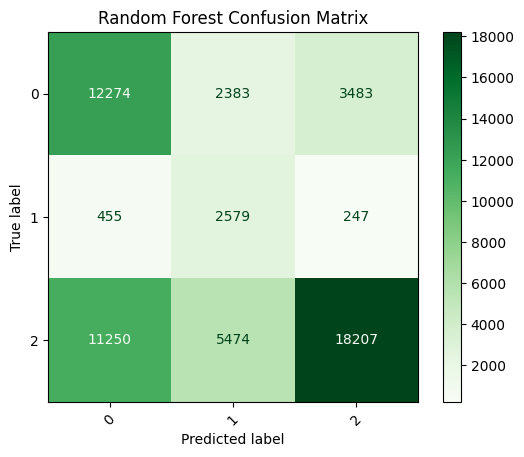

💾 Random Forest model saved to: Models/random_forest_model_ros


In [ ]:
print("⏱️ Running training time estimation...")

subset_frac = 0.01
n_subset = max(2000, int(X_train_tfidf.shape[0] * subset_frac))
subset_idx = np.random.choice(X_train_tfidf.shape[0], size=n_subset, replace=False)

X_sub = X_train_tfidf[subset_idx]
y_sub = y_train.iloc[subset_idx]  

trial_trees = 10
trial_rf = RandomForestClassifier(
    n_estimators=trial_trees,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

t0 = time.time()
trial_rf.fit(X_sub, y_sub)
trial_elapsed = time.time() - t0

print(f"➡️ Trial time: {trial_elapsed:.2f} sec "
      f"({n_subset} samples, {trial_trees} trees)")

n_total = X_train_tfidf.shape[0]
full_trees = 300

est_time = trial_elapsed * (n_total / n_subset) * (full_trees / trial_trees)

print(f"📌 Estimated full training time: "
      f"{est_time/60:.1f} minutes (~{est_time/3600:.2f} hours)\n")


# 1. Train Random Forest Classifier
print("🌲 Training RandomForest Model...")
rf_model = RandomForestClassifier(
    n_estimators=300,      
    max_depth=20,        
    min_samples_split=10,
    min_samples_leaf=4, 
    random_state=42,
    n_jobs=-1              
)
start_time = time.time()
rf_model.fit(X_train_tfidf, y_train)
elapsed = time.time() - start_time
print(f"\n✅ Training finished in {elapsed:.2f} seconds\n")

# 2. Evaluate Model
print("📊 Evaluating model...")
y_pred = rf_model.predict(X_test_tfidf)
train_pred = rf_model.predict(X_train_tfidf)
print(f"Training Accuracy: {accuracy_score(y_train, train_pred)*100:.2f}%")
print(f"Testing  Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}\n")
print("===== Classification Report =====")
print(classification_report(y_test, y_pred))

# 3. Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap="Greens", xticks_rotation=45)
plt.title("Random Forest Confusion Matrix")
plt.show()

# 4. Save the Model
save_dir = "Models/random_forest_model_ros"
os.makedirs(save_dir, exist_ok=True)
joblib.dump(rf_model, f"{save_dir}/random_forest_model.pkl")
print(f"💾 Random Forest model saved to: {save_dir}")

##### **Randomize Search CV HyperTuning For Random Forest**

In [ ]:
# 1. Load Data
train_df = pd.read_csv("Datasets/train_allcase_balanced(ros).csv")
test_df  = pd.read_csv("Datasets/test_allcase_raw.csv")

train_df['preprocessed_news'] = train_df['preprocessed_news'].fillna('')
test_df['preprocessed_news']  = test_df['preprocessed_news'].fillna('')

X_train = train_df['preprocessed_news']
y_train = train_df['label']

X_test  = test_df['preprocessed_news']
y_test  = test_df['label']


# 2. Pipeline (TF-IDF + Random Forest)
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=30000,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.9,
        sublinear_tf=True
    )),
    ('rf', RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    ))
])


# 3. Parameter Search Space
param_dist = {
    'rf__n_estimators': [100, 150, 200, 250, 300],
    'rf__max_depth': [10, 20, 40, 60, None],
    'rf__min_samples_split': [2, 5, 10, 20],
    'rf__min_samples_leaf': [1, 2, 4, 8],
    'rf__bootstrap': [True, False]
}


# 4. Random Search CV
start_time = time.time()
random_search_rf = RandomizedSearchCV(
    estimator=pipeline_rf,
    param_distributions=param_dist,
    n_iter=25,               
    scoring='f1_macro',
    cv=2,                     
    n_jobs=-1,
    verbose=3,
    random_state=42
)

print("🌲 Running RandomizedSearchCV (Random Forest)...")
random_search_rf.fit(X_train, y_train)

print("\n🎯 Best Parameters:", random_search_rf.best_params_)
print(f"🏆 Best CV F1 (macro): {random_search_rf.best_score_:.4f}")
print(f"⏱ Total Search Time: {(time.time() - start_time)/60:.2f} minutes\n")


# 5. Evaluate on Test Set
print("📊 Evaluating on Unseen Test Set...")

best_rf = random_search_rf.best_estimator_
y_pred = best_rf.predict(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test F1 (Macro): {f1_score(y_test, y_pred, average='macro'):.4f}\n")
print("===== Classification Report =====")
print(classification_report(y_test, y_pred))

# 6. Save Model
save_dir = "Models/tuned_random_forest_randomsearch"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "rf_pipeline_randomsearch.pkl")
joblib.dump(best_rf, model_path)

print(f"💾 Model saved at: {model_path}")

🌲 Running RandomizedSearchCV (Random Forest)...
Fitting 2 folds for each of 25 candidates, totalling 50 fits

🎯 Best Parameters: {'rf__n_estimators': 150, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_depth': None, 'rf__bootstrap': False}
🏆 Best CV F1 (macro): 0.9148
⏱ Total Search Time: 73.09 minutes

📊 Evaluating on Unseen Test Set...
Test Accuracy: 0.7753
Test F1 (Macro): 0.7087

===== Classification Report =====
              precision    recall  f1-score   support

           0       0.84      0.47      0.60     18140
           1       0.77      0.61      0.68      3281
           2       0.76      0.95      0.84     34931

    accuracy                           0.78     56352
   macro avg       0.79      0.68      0.71     56352
weighted avg       0.79      0.78      0.76     56352

💾 Model saved at: Models/tuned_random_forest_randomsearch\rf_pipeline_randomsearch.pkl


##### **LightGBM**

In [6]:
# Train LightGBM 
print("⚡ Training LightGBM Model (using your TF-IDF)...")
lgb_model = LGBMClassifier(
    boosting_type='gbdt',
    objective='multiclass',
    num_class=3,
    learning_rate=0.05,
    n_estimators=600,
    num_leaves=80,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
start_time = time.time()
lgb_model.fit(
    X_train_tfidf, y_train,
    eval_set=[(X_test_tfidf, y_test)],
    eval_metric='multi_logloss'
)
elapsed = time.time() - start_time
print(f"\n✅ LightGBM training completed in {elapsed:.2f} seconds\n")

# Model Evaluation
print("📊 Evaluating model...")
y_pred = lgb_model.predict(X_test_tfidf)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Weighted F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}\n")
print("===== Classification Report =====")
print(classification_report(y_test, y_pred))

# Save Model
save_dir = "Models/lightgbm_model_ros"
os.makedirs(save_dir, exist_ok=True)
joblib.dump(lgb_model, f"{save_dir}/lightgbm_model.pkl")
joblib.dump(rostfidf, f"{save_dir}/tfidf_vectorizer.pkl")
print(f"💾 LightGBM model & TF-IDF saved to: {save_dir}")


⚡ Training LightGBM Model (using your TF-IDF)...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 17.194850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895433
[LightGBM] [Info] Number of data points in the train set: 419166, number of used features: 29996
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612

✅ LightGBM training completed in 853.98 seconds

📊 Evaluating model...


c:\Python_Env\fyp_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Test Accuracy: 0.8824
Weighted F1 Score: 0.8852

===== Classification Report =====
              precision    recall  f1-score   support

           0       0.86      0.87      0.86     18140
           1       0.56      0.75      0.64      3281
           2       0.94      0.90      0.92     34931

    accuracy                           0.88     56352
   macro avg       0.79      0.84      0.81     56352
weighted avg       0.89      0.88      0.89     56352

💾 LightGBM model & TF-IDF saved to: Models/lightgbm_model_ros


##### **Randomize Search CV HyperTuning For LightGBM**

In [7]:
# 1. Define LightGBM model
lgb_clf = LGBMClassifier(
    boosting_type='gbdt',
    objective='multiclass',
    num_class=len(np.unique(y_train)),
    n_jobs=-1,
    random_state=42,
    n_estimators=600,    
)

# 2. Search space 
param_dist = {
    'num_leaves': [31, 63, 127],
    'max_depth': [6, 10, -1],
    'learning_rate': [0.05, 0.1],
    'min_child_samples': [10, 20, 40],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'reg_alpha': [0.0, 0.2, 0.5],
    'reg_lambda': [0.0, 0.2, 0.5],
}

# 3. Randomized Search 
random_search_lgb = RandomizedSearchCV(
    estimator=lgb_clf,
    param_distributions=param_dist,
    n_iter=10,                
    scoring='f1_macro',
    cv=2,                     
    verbose=2,
    n_jobs=-1,
    random_state=42
)
print("🚀 Running FAST RandomizedSearchCV for LightGBM...")
start_time = time.time()

random_search_lgb.fit(
    X_train_tfidf,
    y_train,
    eval_set=[(X_test_tfidf, y_test)],
    eval_metric='multi_logloss',
    callbacks=None
)
elapsed_min = (time.time() - start_time) / 60
print(f"⏱ FAST hyperparameter search completed in {elapsed_min:.2f} minutes\n")

print("🎯 Best Parameters Found:")
print(random_search_lgb.best_params_)
print(f"\n🏆 Best CV F1 (Macro): {random_search_lgb.best_score_:.4f}\n")


# 5. Evaluate tuned model on test set
best_lgb = random_search_lgb.best_estimator_
y_pred = best_lgb.predict(X_test_tfidf)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test F1 (Macro): {f1_score(y_test, y_pred, average='macro'):.4f}\n")
print("===== Classification Report =====")
print(classification_report(y_test, y_pred))


# 6. Save model
save_dir = "Models/tuned_lightgbm_ros"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "lightgbm_fast_randomsearch.pkl")
joblib.dump(best_lgb, model_path)
print(f"💾 Tuned LightGBM model saved to: {model_path}")


🚀 Running FAST RandomizedSearchCV for LightGBM...
Fitting 2 folds for each of 10 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 16.568910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 895444
[LightGBM] [Info] Number of data points in the train set: 419166, number of used features: 30000
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
⏱ FAST hyperparameter search completed in 94.55 minutes

🎯 Best Parameters Found:
{'subsample': 0.7, 'reg_lambda': 0.5, 'reg_alpha': 0.2, 'num_leaves': 63, 'min_child_samples': 10, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 1.0}

🏆 Best CV F1 (Macro): 0.9042



c:\Python_Env\fyp_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Test Accuracy: 0.8748
Test F1 (Macro): 0.7962

===== Classification Report =====
              precision    recall  f1-score   support

           0       0.86      0.85      0.86     18140
           1       0.52      0.75      0.62      3281
           2       0.93      0.90      0.91     34931

    accuracy                           0.87     56352
   macro avg       0.77      0.84      0.80     56352
weighted avg       0.89      0.87      0.88     56352

💾 Tuned LightGBM model saved to: Models/tuned_lightgbm_ros\lightgbm_fast_randomsearch.pkl


##### **Multinomonial Naive Bayes**

In [3]:
# Train Multinomial Naive Bayes
print("⚡ Training Multinomial Naive Bayes (using your TF-IDF)...")

nb_model = MultinomialNB()

start_time = time.time()

nb_model.fit(X_train_tfidf, y_train)

elapsed = time.time() - start_time
print(f"\n✅ Naive Bayes training completed in {elapsed:.4f} seconds\n")

# Evaluate Model
print("📊 Evaluating Naive Bayes model...")

y_pred_nb = nb_model.predict(X_test_tfidf)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"Weighted F1 Score: {f1_score(y_test, y_pred_nb, average='weighted'):.4f}\n")

print("===== Classification Report =====")
print(classification_report(y_test, y_pred_nb))

#  Save Model + TF-IDF
save_dir = "Models/naive_bayes_model_ros"
os.makedirs(save_dir, exist_ok=True)

joblib.dump(nb_model, f"{save_dir}/naive_bayes_model.pkl")
joblib.dump(rostfidf, f"{save_dir}/tfidf_vectorizer.pkl")

print(f"💾 Naive Bayes model & TF-IDF saved to: {save_dir}")

⚡ Training Multinomial Naive Bayes (using your TF-IDF)...

✅ Naive Bayes training completed in 0.0893 seconds

📊 Evaluating Naive Bayes model...
Test Accuracy: 0.7578
Weighted F1 Score: 0.7645

===== Classification Report =====
              precision    recall  f1-score   support

           0       0.64      0.79      0.71     18140
           1       0.50      0.72      0.59      3281
           2       0.89      0.74      0.81     34931

    accuracy                           0.76     56352
   macro avg       0.68      0.75      0.70     56352
weighted avg       0.79      0.76      0.76     56352

💾 Naive Bayes model & TF-IDF saved to: Models/naive_bayes_model_ros


##### **Hyperparameter Tuning of Multinominal Naive Bayes With GridSearch**

In [4]:
# Define Parameter Grid
param_grid = {
    'alpha': [0.1, 0.3, 0.5, 1.0, 3.0, 5.0],
    'fit_prior': [True, False]
}
nb = MultinomialNB()

grid_nb = GridSearchCV(
    estimator=nb,
    param_grid=param_grid,
    scoring='f1_weighted',   
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Train Model
print("🔍 Running GridSearchCV for Multinomial Naive Bayes...")
start_time = time.time()
grid_nb.fit(X_train_tfidf, y_train)
elapsed = time.time() - start_time

print(f"\n⏳ GridSearch Completed in {elapsed:.2f} seconds")
print("🏆 Best Parameters:", grid_nb.best_params_)
print(f"Best CV Score (Weighted F1): {grid_nb.best_score_:.4f}\n")

best_nb_model = grid_nb.best_estimator_

# Evaluate Tuned Model
print("📊 Evaluating Tuned Naive Bayes Model...")

y_pred_nb = best_nb_model.predict(X_test_tfidf)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"Weighted F1 Score: {f1_score(y_test, y_pred_nb, average='weighted'):.4f}\n")
print("===== Classification Report =====")
print(classification_report(y_test, y_pred_nb))

# Save Model + TF-IDF
save_dir = "Models/naive_bayes_tuned_ros"
os.makedirs(save_dir, exist_ok=True)
joblib.dump(best_nb_model, f"{save_dir}/naive_bayes_model.pkl")
joblib.dump(rostfidf, f"{save_dir}/tfidf_vectorizer.pkl")
print(f"💾 Tuned Naive Bayes model & TF-IDF saved to: {save_dir}")

🔍 Running GridSearchCV for Multinomial Naive Bayes...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

⏳ GridSearch Completed in 5.84 seconds
🏆 Best Parameters: {'alpha': 0.1, 'fit_prior': True}
Best CV Score (Weighted F1): 0.7764

📊 Evaluating Tuned Naive Bayes Model...
Test Accuracy: 0.7592
Weighted F1 Score: 0.7657

===== Classification Report =====
              precision    recall  f1-score   support

           0       0.64      0.80      0.71     18140
           1       0.50      0.72      0.59      3281
           2       0.89      0.74      0.81     34931

    accuracy                           0.76     56352
   macro avg       0.68      0.75      0.70     56352
weighted avg       0.79      0.76      0.77     56352

💾 Tuned Naive Bayes model & TF-IDF saved to: Models/naive_bayes_tuned_ros


##### **Additional Graph for Model Evaluation**

In [39]:
import joblib
import pickle

svm_model_ros_path  = "Models/svm_model_ros/linear_svc_model.pkl"
tuned_svm_model_ros_path  = "Models/tuned_svm_model_ros/linear_svc_fintext_model.pkl"

rf_model_ros_path   = "Models/random_forest_model_ros/random_forest_model.pkl"
rf_tuned_model_ros_path   = "Models/tuned_random_forest_randomsearch/rf_pipeline_randomsearch.pkl"

lgbm_model_ros_path = "Models/lightgbm_model_ros/lightgbm_model.pkl"
tuned_lgbm_model_ros_path = "Models/tuned_lightgbm_ros/lightgbm_fast_randomsearch.pkl"

nb_model_ros_path   = "Models/naive_bayes_model_ros/naive_bayes_model.pkl"
tuned_nb_model_ros_path   = "Models/naive_bayes_tuned_ros/naive_bayes_model.pkl"

with open(svm_model_ros_path, "rb") as f:
    svm_model_ros = joblib.load(f)

with open(tuned_svm_model_ros_path, "rb") as f: 
    tuned_svm_model_ros = joblib.load(f)

with open(rf_model_ros_path, "rb") as f:
    rf_model_ros = joblib.load(f)

with open(rf_tuned_model_ros_path, "rb") as f:
    tuned_rf_model_ros = joblib.load(f)

with open(lgbm_model_ros_path, "rb") as f:
    lgbm_model_ros = joblib.load(f)

with open(tuned_lgbm_model_ros_path, "rb") as f:
    tuned_lgbm_model_ros = joblib.load(f)

with open(nb_model_ros_path, "rb") as f:
    nb_model_ros = joblib.load(f)

with open(tuned_nb_model_ros_path, "rb") as f:
    tuned_nb_model_ros = joblib.load(f)

feature_names = np.array(rostfidf.get_feature_names_out())


##### **Feature Important Graph**

##### **Linear SVC**

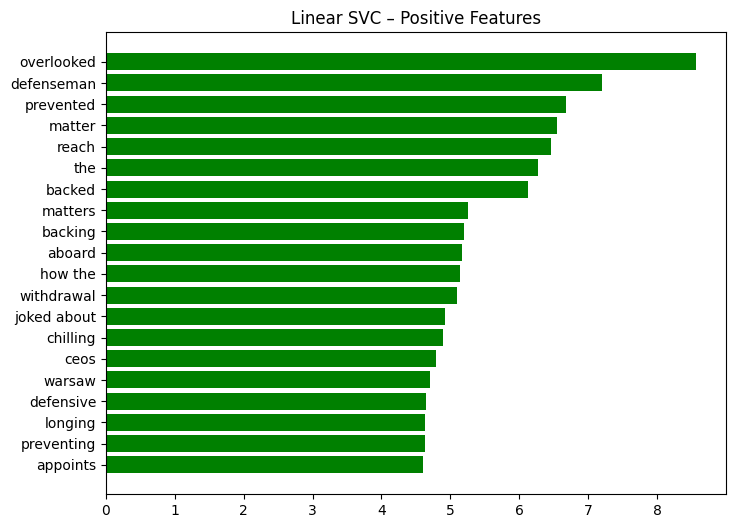

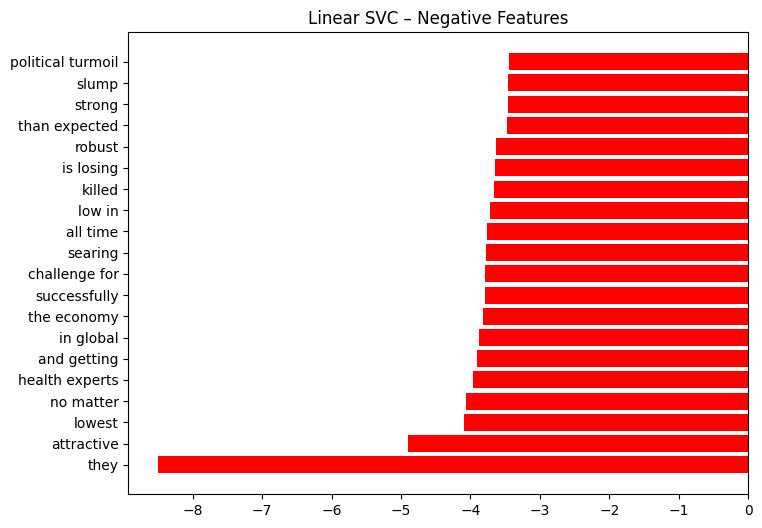

In [ ]:
def plot_svm_features(model, top_n=20):
    coef = model.coef_[0] if model.coef_.ndim == 1 else model.coef_[1]

    pos_idx = np.argsort(coef)[-top_n:]
    neg_idx = np.argsort(coef)[:top_n]

    plt.figure(figsize=(8,6))
    plt.barh(feature_names[pos_idx], coef[pos_idx], color='green')
    plt.title("Linear SVC – Positive Features")
    plt.show()

    plt.figure(figsize=(8,6))
    plt.barh(feature_names[neg_idx], coef[neg_idx], color='red')
    plt.title("Linear SVC – Negative Features")
    plt.show()

plot_svm_features(svm_model_ros)

##### **Hyperparameter TUned Linear SVC**

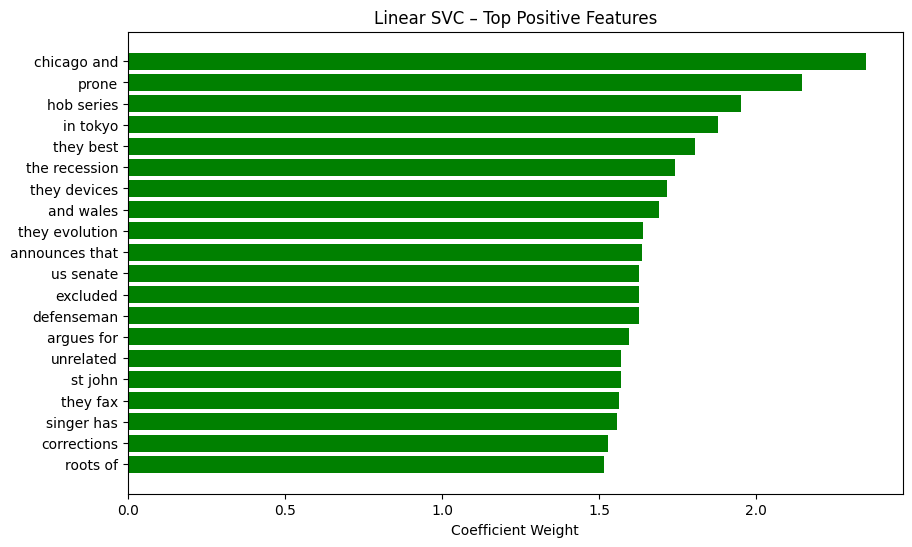

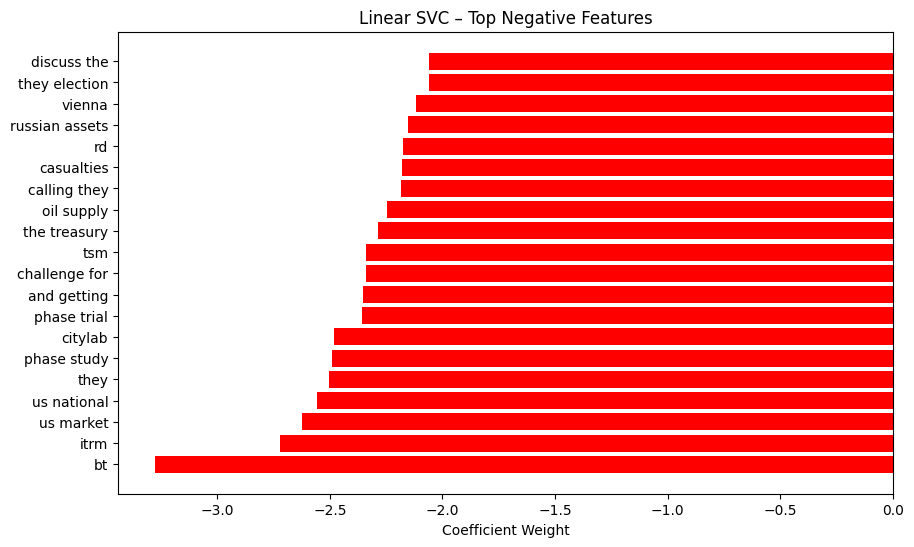

In [ ]:
def plot_svm_features(pipeline_model, top_n=20):
    # Extract LinearSVC from pipeline
    svc = pipeline_model.named_steps["svm"]

    coef = svc.coef_

    if coef.shape[0] > 1:
        coef = coef.mean(axis=0)  
    else:
        coef = coef.flatten()


    tfidf = pipeline_model.named_steps["tfidf"]
    feature_names = np.array(tfidf.get_feature_names_out())

    top_positive = np.argsort(coef)[-top_n:]
    top_negative = np.argsort(coef)[:top_n]

    plt.figure(figsize=(10,6))
    plt.barh(feature_names[top_positive], coef[top_positive], color='green')
    plt.title("Linear SVC – Top Positive Features")
    plt.xlabel("Coefficient Weight")
    plt.show()

    # Plot negative features
    plt.figure(figsize=(10,6))
    plt.barh(feature_names[top_negative], coef[top_negative], color='red')
    plt.title("Linear SVC – Top Negative Features")
    plt.xlabel("Coefficient Weight")
    plt.show()

plot_svm_features(tuned_svm_model_ros)


##### **Random Forest**

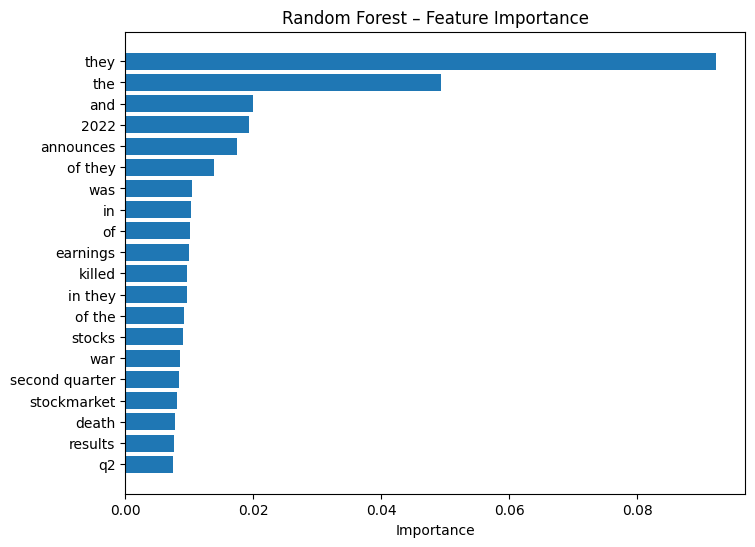

In [27]:
def plot_rf_importance(model, top_n=20):
    importance = model.feature_importances_
    idx = np.argsort(importance)[-top_n:]

    plt.figure(figsize=(8,6))
    plt.barh(feature_names[idx], importance[idx])
    plt.title("Random Forest – Feature Importance")
    plt.xlabel("Importance")
    plt.show()

plot_rf_importance(rf_model_ros)


##### **Hyperparameter Tuned Random Forest**

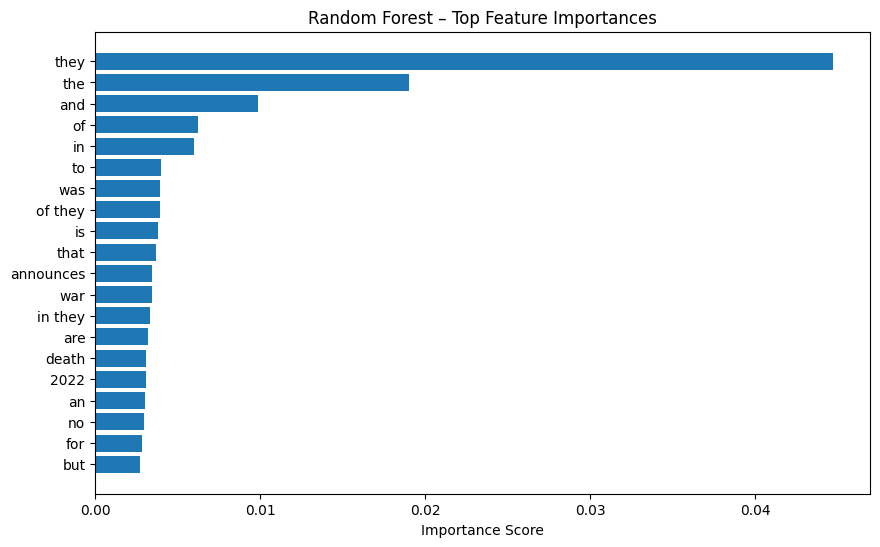

In [26]:
def plot_rf_features(pipeline_model, top_n=20):
    # Extract components
    rf = pipeline_model.named_steps["rf"]
    tfidf = pipeline_model.named_steps["tfidf"]

    # Feature importance
    importance = rf.feature_importances_
    feature_names = np.array(tfidf.get_feature_names_out())

    # Top features
    idx = np.argsort(importance)[-top_n:]

    plt.figure(figsize=(10,6))
    plt.barh(feature_names[idx], importance[idx])
    plt.title("Random Forest – Top Feature Importances")
    plt.xlabel("Importance Score")
    plt.show()

plot_rf_features(tuned_rf_model_ros)


##### **LightGBM**

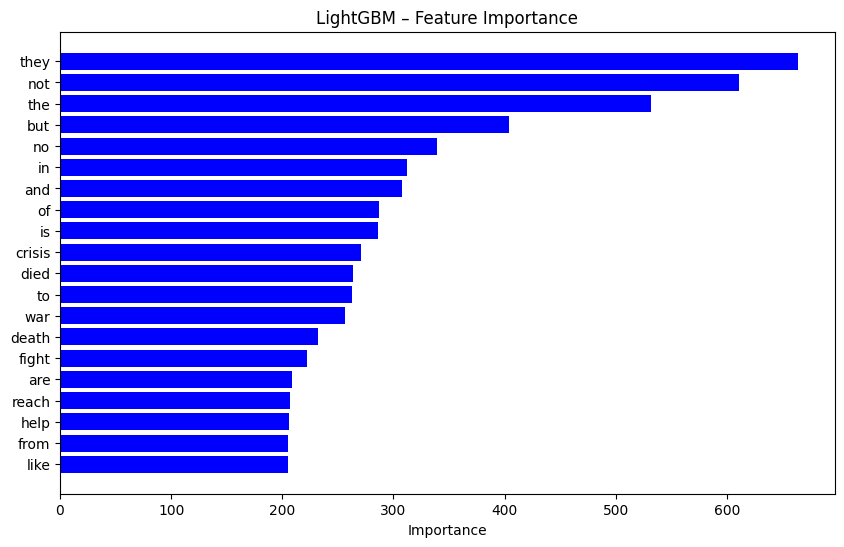

In [ ]:
def plot_lgbm_importance(lgbm_model, feature_names, top_n=20):
    importance = lgbm_model.feature_importances_
    idx = np.argsort(importance)[-top_n:]

    plt.figure(figsize=(10,6))
    plt.barh(np.array(feature_names)[idx], importance[idx], color='blue')
    plt.title("LightGBM – Feature Importance")
    plt.xlabel("Importance")
    plt.show()


plot_lgbm_importance(lgbm_model_ros, rostfidf.get_feature_names_out(), top_n=20)

##### **Hyperparameter LightGBM**

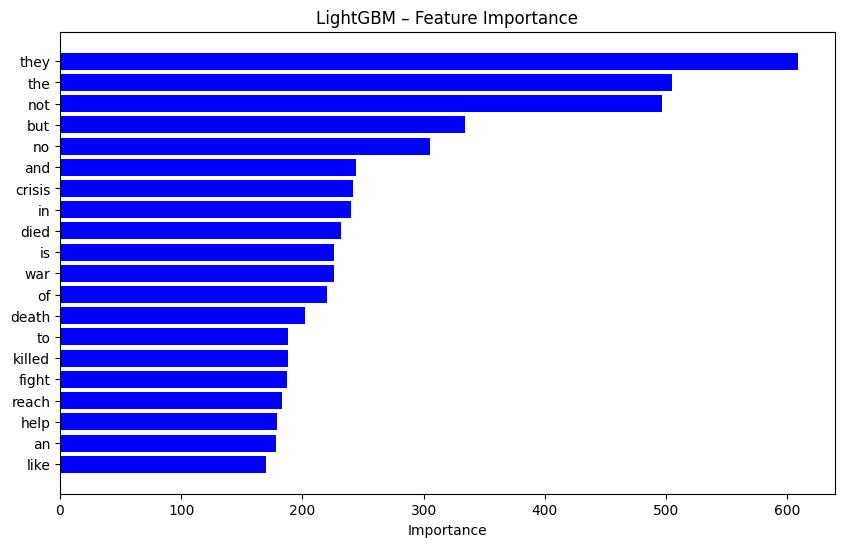

In [27]:
def plot_lgbm_importance(lgbm_model, feature_names, top_n=20):
    importance = lgbm_model.feature_importances_
    idx = np.argsort(importance)[-top_n:]

    plt.figure(figsize=(10,6))
    plt.barh(np.array(feature_names)[idx], importance[idx], color='blue')
    plt.title("LightGBM – Feature Importance")
    plt.xlabel("Importance")
    plt.show()


plot_lgbm_importance(tuned_lgbm_model_ros, rostfidf.get_feature_names_out(), top_n=20)

##### **Multinominal Naive Bayes**

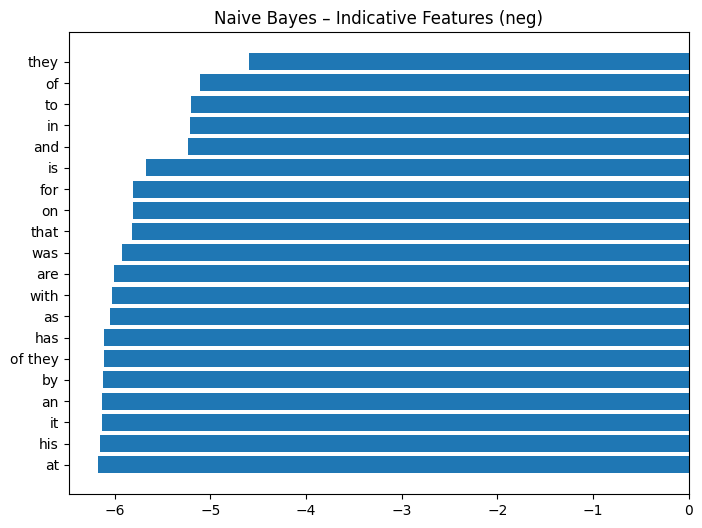

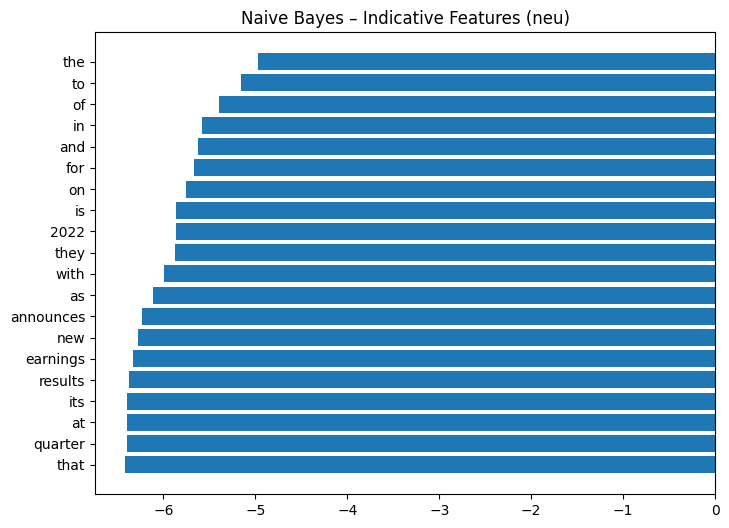

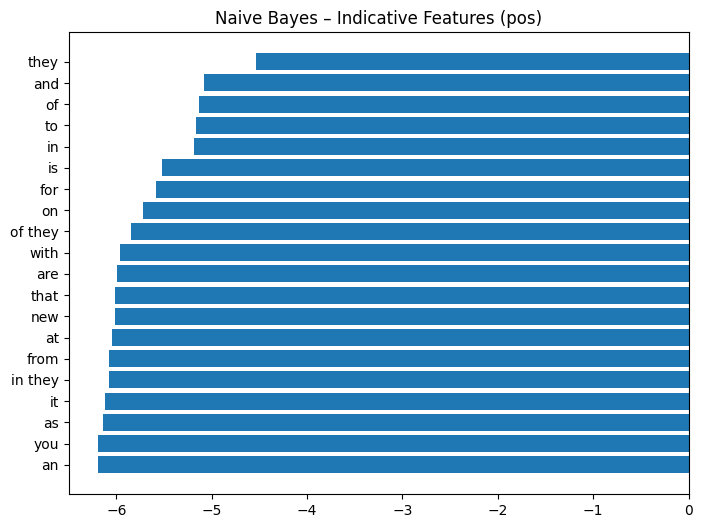

In [32]:
def plot_nb_features(model, top_n=20):
    log_probs = model.feature_log_prob_

    for i, cls in enumerate(["neg", "neu", "pos"]):
        idx = np.argsort(log_probs[i])[-top_n:]

        plt.figure(figsize=(8,6))
        plt.barh(feature_names[idx], log_probs[i][idx])
        plt.title(f"Naive Bayes – Indicative Features ({cls})")
        plt.show()

plot_nb_features(nb_model_ros)


##### **Hyperparameter Tuned Multinominal Naive Bayes**

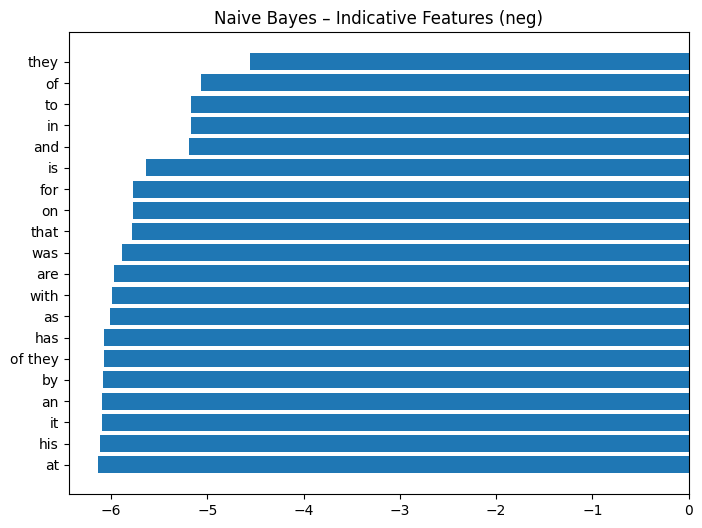

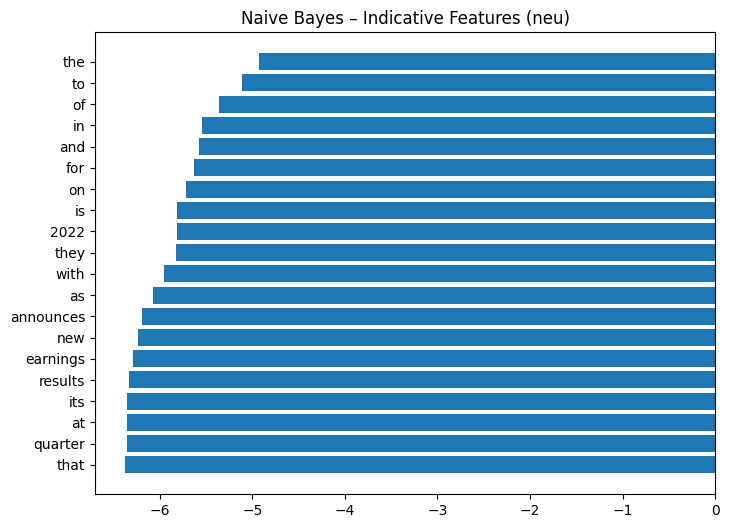

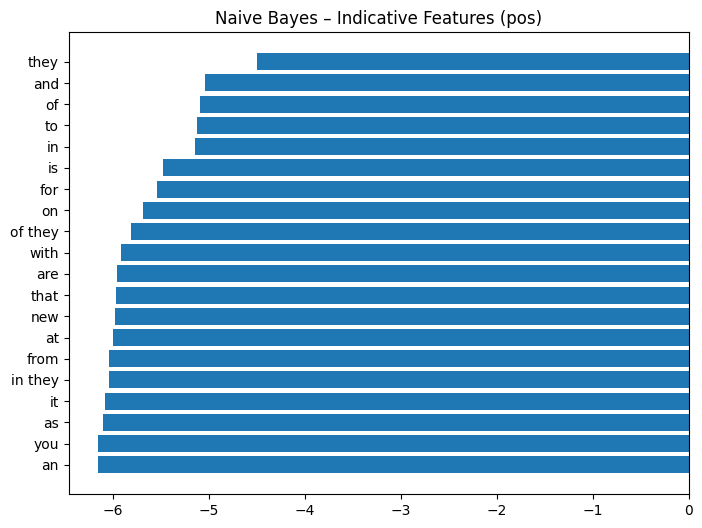

In [28]:
def plot_nb_features(model, top_n=20):
    log_probs = model.feature_log_prob_

    for i, cls in enumerate(["neg", "neu", "pos"]):
        idx = np.argsort(log_probs[i])[-top_n:]

        plt.figure(figsize=(8,6))
        plt.barh(feature_names[idx], log_probs[i][idx])
        plt.title(f"Naive Bayes – Indicative Features ({cls})")
        plt.show()

plot_nb_features(tuned_nb_model_ros)


##### **Learning Curve**

In [6]:
def plot_learning_curve(model, X, y, title):
    scorer = make_scorer(f1_score, average="macro")

    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        cv=5,
        scoring=scorer,
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1
    )

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_scores.mean(axis=1), label="Train F1")
    plt.plot(train_sizes, val_scores.mean(axis=1), label="Validation F1")
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("Macro-F1")
    plt.legend()
    plt.grid(True)
    plt.show()


In [12]:
def plot_learning_curve_tuned(model, X, y, title):
    from sklearn.model_selection import learning_curve
    from sklearn.metrics import make_scorer, f1_score
    import matplotlib.pyplot as plt
    import numpy as np

    scorer = make_scorer(f1_score, average="macro")

    train_sizes = np.linspace(0.1, 1.0, 5)

    train_sizes, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=train_sizes,
        cv=3,
        scoring=scorer,
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label="Train F1")
    plt.plot(train_sizes, val_scores.mean(axis=1), marker='o', label="Validation F1")
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("Macro-F1")
    plt.legend()
    plt.grid(True)
    plt.show()


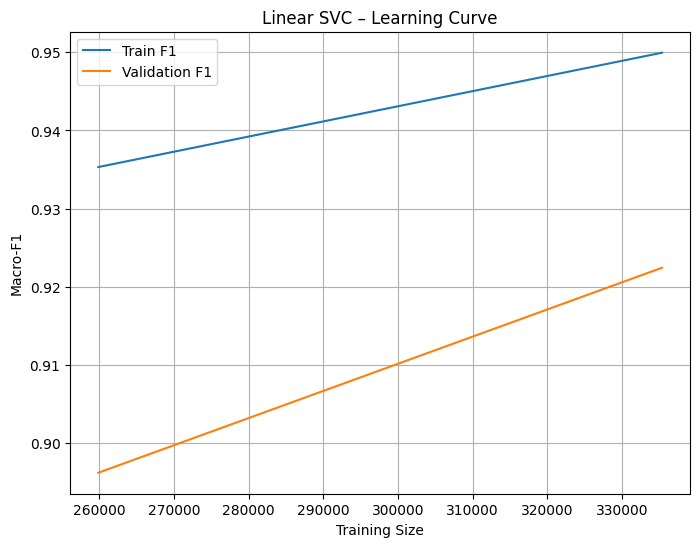

In [29]:
X_tfidf = rostfidf.transform(X_train)
y = y_train

plot_learning_curve(svm_model_ros, X_tfidf, y, "Linear SVC – Learning Curve")

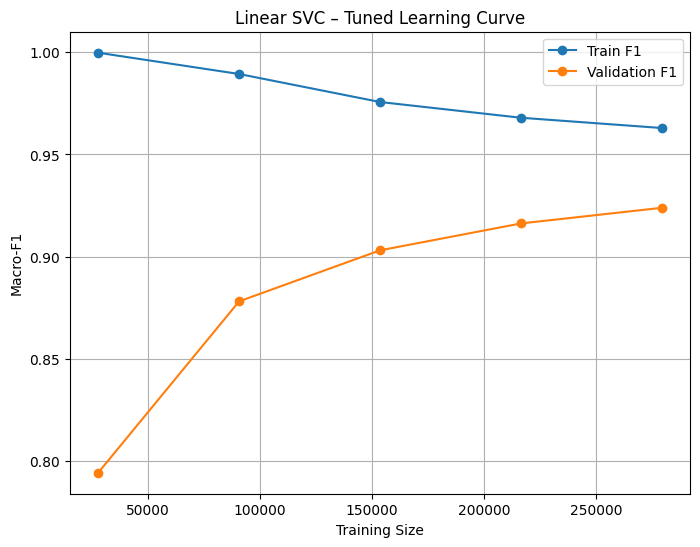

In [17]:
X_tfidf = rostfidf.transform(X_train) 
y = y_train

plot_learning_curve_tuned(tuned_svm_model_ros, X_train, y, "Linear SVC – Tuned Learning Curve")

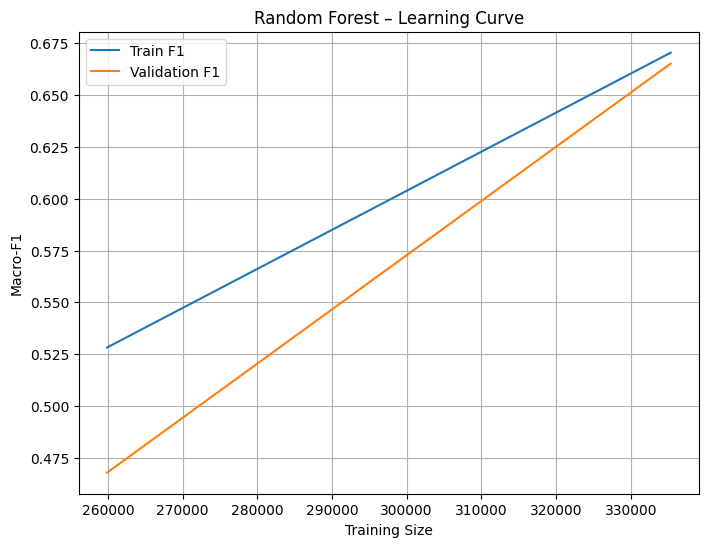

In [30]:
# TF-IDF transformed data
X_tfidf = rostfidf.transform(X_train)
y = y_train

plot_learning_curve(rf_model_ros, X_tfidf, y, "Random Forest – Learning Curve")

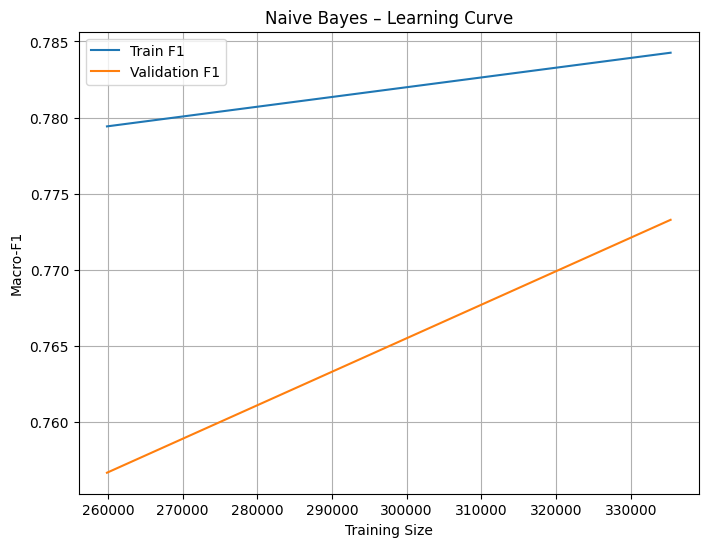

In [31]:
X_tfidf = rostfidf.transform(X_train)
y = y_train
plot_learning_curve(nb_model_ros, X_tfidf, y, "Naive Bayes – Learning Curve")

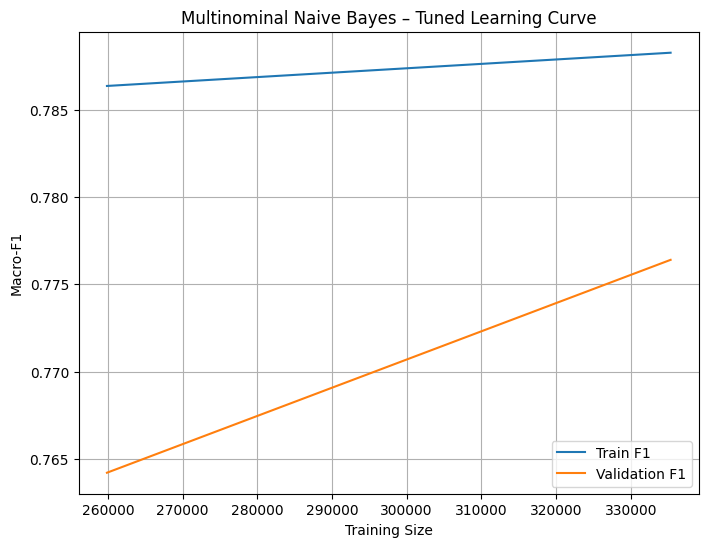

In [41]:
plot_learning_curve(tuned_nb_model_ros, X_tfidf, y, "Multinominal Naive Bayes – Tuned Learning Curve")